# The equilibrium year as tuning parameter
The equilibrium year $t^*$ is a model parameter, rather than a physical given year. Hence, it can be used to tune the model behavior in a similar fashion than the precipitation scaling factor and the "Glen A" creep parameter.

1. **Minimal working example:** Piecing together a full model run from start to finish, where it is possible to choose the value for $t^*$.
2. **Analyse results:** A script runs the model for a set of different values of $t^*$ ans stores the modeled glacier length in a file. Here I compute the correlation between model output and reference values.

## 1. Minimal working example
Hereafter I set up a working example, starting from the preprocessing and ending with a model run over the entire HistAlp period. Somewhere along an arbitray value for $t^*$ is chosen (Section **Climate and mass balance parameters**). This code serves me as guide, when I write the script which test the model output for different values of $t^*$ (see `../code/t_star_tuning.py`).

### Import section

In [58]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities, rmsd
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

# import my modules
import sys
sys.path.append('../code/')
from utils import rmsd_anomaly, get_leclercq_length

### Initialize

Loading the OGGM default parameter file and changing/setting needed parameters and paths:
- specifying the working directory
- using intersections, since the Upper Grindelwald Glacier is confined by other glaciers (names?!)
- using a big local grid (high border number), to allow for a strongly advancing glacier
- using HistAlp data set as climate data and setting the corresponding hyper parameters

In [59]:
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
cfg.PATHS['working_dir'] = wdir

# using intersects
cfg.PARAMS['use_intersects'] = True

# define the size of the local grid
cfg.PARAMS['border'] = 50

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-10-22 21:59:49: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


### Preprocessing

Run the needed preprocessing routines, including:
- the RGI entity and the glacier directory
- GIS and centerline tasks
- mass balance and climate tasks
- ice thicknes inversion

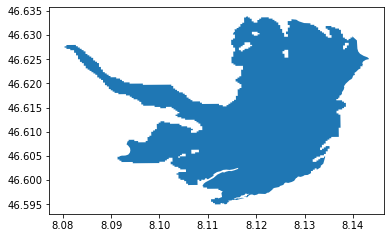

In [60]:
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]
rgi_df.plot()

In [61]:
# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

In [62]:
# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

#### GIS

In [63]:
# GIS tasks
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)
gdir

2019-10-22 21:59:53: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-10-22 21:59:53: oggm.core.gis: (RGI60-11.01270) glacier_masks


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (192, 183)
  Grid (dx, dy): (52.0, -52.0)

#### Centerlines

In [64]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-10-22 21:59:53: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-10-22 21:59:54: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-10-22 21:59:54: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-10-22 21:59:54: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-10-22 21:59:54: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-10-22 21:59:56: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-10-22 21:59:56: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-10-22 21:59:57: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


#### Climate and mass balance parameters

In [65]:
# process the HistAlp climate file
climate.process_histalp_data(gdir)
# read and view the "climate info" file
ci = gdir.read_pickle('climate_info')
ci

2019-10-22 21:59:58: oggm.core.climate: (RGI60-11.01270) process_histalp_data


{'baseline_climate_source': 'HISTALP',
 'baseline_hydro_yr_0': 1802,
 'baseline_hydro_yr_1': 2014}

In [66]:
# compute the local equilibrium year t* and
# the corresponding temperature sensitivity mu*
# using the reference table (t_star = None)
t_star = 1909
bias = None
climate.local_t_star(gdir, tstar=t_star, bias=bias)
climate.mu_star_calibration(gdir)

2019-10-22 22:00:05: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-10-22 22:00:05: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-10-22 22:00:06: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


#### Mass balance

In [67]:
# read climate info file
ci = gdir.read_pickle('climate_info')
y0 = ci['baseline_hydro_yr_0']
y1 = ci['baseline_hydro_yr_1']

In [68]:
# istance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

#### Inversion

In [69]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
# use the default creep parameter to perform the ice thicknes inversion
inv_glen_a = cfg.PARAMS['inversion_glen_a']
inversion.mass_conservation_inversion(gdir, glen_a=inv_glen_a)
inversion.filter_inversion_output(gdir)

2019-10-22 22:00:14: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-10-22 22:00:14: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-10-22 22:00:14: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


2019-10-22 22:00:16: oggm.core.inversion: (RGI60-11.01270) distribute_thickness_interp
2019-10-22 22:00:16: oggm.core.gis: (RGI60-11.01270) gridded_attributes


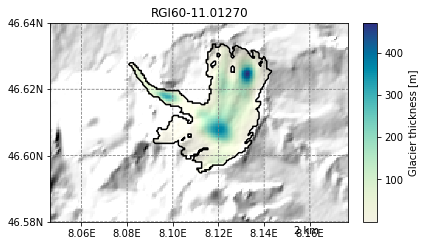

In [70]:
# visualize ice thickness
inversion.distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness([gdir])

### Dynamic model

In [71]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-10-22 22:00:17: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


### Model
To get a first idea, the model runs over the entire HistAlp period (1802 - 2014).

In [72]:
# read needed files and parameters thereout

# climate info file, start and end of climate period
ci =  gdir.read_pickle('climate_info')
y0 = ci['baseline_hydro_yr_0']
y1 = ci['baseline_hydro_yr_1']

# model flowlines
fls = gdir.read_pickle('model_flowlines')

# mass balance calibration parameters
local_mustar = gdir.read_json('local_mustar')
t_star = local_mustar['t_star']
bias = local_mustar['bias']
mu_star = local_mustar['mu_star_glacierwide']

In [73]:
# instance the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model, y0=y0)
# run model over entire HistAlp period, store results
run_ds, diag_ds = model.run_until_and_store(y1)

### Results
I restrict the analysis to the modeled glacier length, since we only have length (change) measurements to compare with.

In [74]:
# create length DataFrame with model years as index
# and the corresponding t* as column(s)
length = pd.DataFrame(index=np.arange(y0,y1+1))
length.index.name = 'year'
# extract the length data from the model output
length.loc[:,t_star] = diag_ds.length_m.to_dataframe()['length_m']

In [75]:
# take a first look at the length data
length.head()

,1909
year,
1802,6136.0
1803,6240.0
1804,6136.0
1805,6240.0
1806,6136.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x129340160>,
      dtype=object)

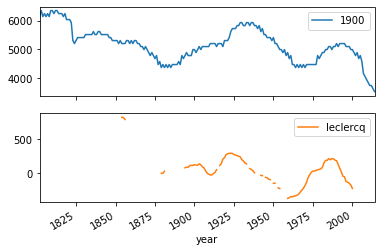

In [19]:
# read the mesuared length changes (Leclercq data set)
length_ref = get_leclercq_length(rgi_id='11.01270')
# add reference to the length dataset
length['leclercq'] = length_ref
# plot modeled length and observed length changes
length.plot(subplots=True);

Here we go, not much of an insigth to be gained here. But I got what I wanted, which is a working example which produces sensible results for any chosen value of $t^*$ (qualitatively speaking).

## 2. Look at results of script
While I use this notebook to get an idea of what my code is actually producing, I use a regular python script to do the "heavy lifting". In this case the scipts `../code/t_star_tuning.py` runs the code from above for values of $t^*$ ranging from 1817 up to 1997. This results in a dataset with 91 model runs over the entire HistAlp period. Same as above, we only look at the modeled glacier lengths...

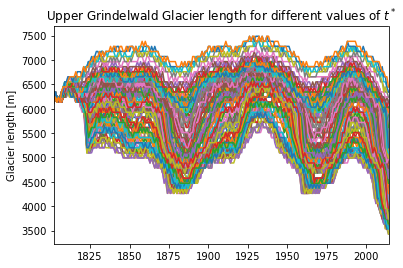

In [100]:
# define path to the file
fn = '/Users/oberrauch/work/grindelwald/data/length_t_star.csv'
# read file using pandas
length = pd.read_csv(fn, index_col=0)
# make sure the column indices (years) are numbers
length.columns = length.columns.astype(int)
# take a first look (misregarding the reference values)
ax = length.iloc[:-1].T.dropna().plot(legend=False)
ax.set_ylabel('Glacier length [m]')
ax.set_title('Upper Grindelwald Glacier length for different values of $t^*$');

In [101]:
# get modeled glacier length and reference length measurements
# as two seperate DataFrames
length_model = length.drop('ref_dl').dropna(axis=1)
length_ref = length.loc['ref_dl'] 

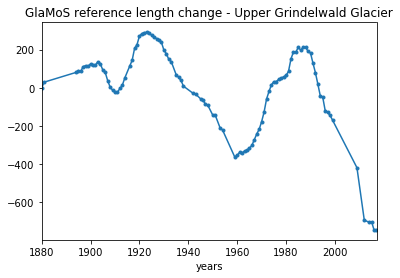

In [102]:
# I'll use the glamos length reference, which is equal to the
# Leclercq record between 1880 and 2000 but goes up to 2017
fn = '/Users/oberrauch/work/grindelwald/data/length_ref_glamos.csv'
length_ref = pd.read_csv(fn, index_col=0)
length_ref.plot(marker='.', legend=False)
plt.gca().set_title('GlaMoS reference length change - Upper Grindelwald Glacier');

In [103]:
# run the mass balance calibration with default settings,
# i.e. computeing the t* from the reference table
climate.local_t_star(gdir)
loc_mu_star = gdir.read_json('local_mustar')

2019-10-22 23:31:47: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-10-22 23:31:47: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909


In [104]:
# compute correlation between model output (for a single t*)
# and the reference length records, for all model runs
corr = [pd.concat([length_ref, l_mod], axis=1).corr().iloc[0,1] for t_star, l_mod in length_model.iterrows()]
# add indices to increased readability
corr = pd.Series(corr, index=length_model.index)
corr.index = corr.index.astype(int)

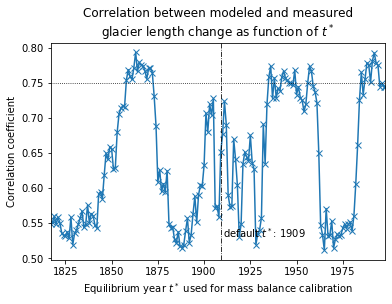

In [105]:
# visualize results
corr.plot(marker='x')
plt.axhline(0.75, c='k', ls=':', lw=0.8, label='arbitrary corr. threshold')
plt.axvline(loc_mu_star['t_star'], c='k', ls='-.', lw=0.8, label='default $t^*$')
plt.title('Correlation between modeled and measured\nglacier length change as function of $t^*$')
plt.ylabel('Correlation coefficient')
plt.xlabel('Equilibrium year $t^*$ used for mass balance calibration')
plt.text(1909+1, 0.53, 'default $t^*$: ' + str(loc_mu_star['t_star']));

In [110]:
bias

59.39856206984309

The plot above shows the correlation between the modeled glacier length and the reference measurements as a function of the equilibrium year $t^*$ used during the mass balance calibration. As can be seen, there is a vast difference in correlation between different values of $t^*$. A higher correlation (around/above .75) is optained for values of $t^*$ equal to 1862, 1867, 1872 or 1937, 1942, 1947, (1952), 1957 or 1987, 1992, 1997.

In contrast, the model calibrated with the default value $t^*$ = 1909 (obtained from the reference table, but with mass balance residual $\beta^*$ = 0) produces results which correlate less (about .65) with the measurements. When the mass balance residual $\beta^*$ = 59 mm w.e. yr$^{-1}$ (derived from the reference table) is used, the correlation increases to over .72.